In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from problems.time_series.common import trend, seasonality, noise, windowed_dataset, plot_series

tf.__version__

import typing
from tensorflow import keras

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras

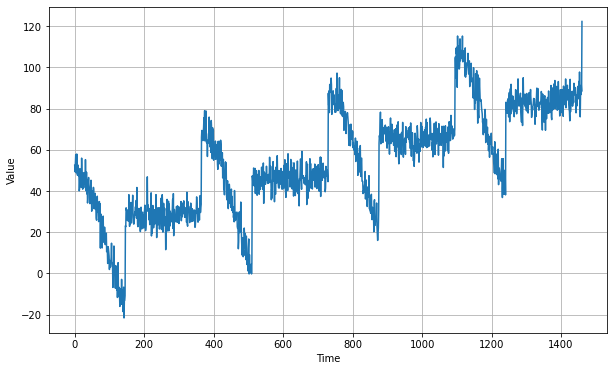

In [2]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [3]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2022-02-15 21:29:27.085836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 21:29:27.089284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 21:29:27.089429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 21:29:27.090141: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
history = model.fit(dataset, epochs=250)

Epoch 1/250
31/31 [==============================] - 1s 5ms/step - loss: 408.9017


2022-02-15 21:29:28.195244: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 2/250
31/31 [==============================] - 0s 858us/step - loss: 128.3478
Epoch 3/250
31/31 [==============================] - 0s 2ms/step - loss: 105.8293
Epoch 4/250
31/31 [==============================] - 0s 2ms/step - loss: 99.6493
Epoch 5/250
31/31 [==============================] - 0s 2ms/step - loss: 92.9791
Epoch 6/250
31/31 [==============================] - 0s 3ms/step - loss: 89.3779
Epoch 7/250
31/31 [==============================] - 0s 2ms/step - loss: 84.0406
Epoch 8/250
31/31 [==============================] - 0s 889us/step - loss: 80.5240
Epoch 9/250
31/31 [==============================] - 0s 2ms/step - loss: 78.4647
Epoch 10/250
31/31 [==============================] - 0s 857us/step - loss: 75.7806
Epoch 11/250
31/31 [==============================] - 0s 849us/step - loss: 74.6374
Epoch 12/250
31/31 [==============================] - 0s 1ms/step - loss: 72.2919
Epoch 13/250
31/31 [==============================] - 0s 922us/step - loss: 71.0370
Epoch 14/250

In [5]:
print(series[1:21])
print(model.predict(series[1:21][np.newaxis]))

[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938]
[[47.565556]]


5.057124


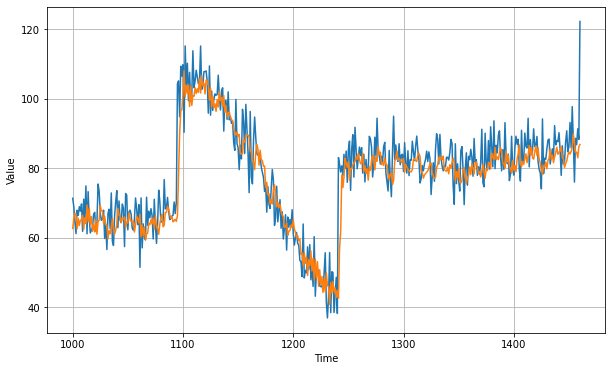

In [6]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

(1e-08, 0.001, 0.0, 300.0)

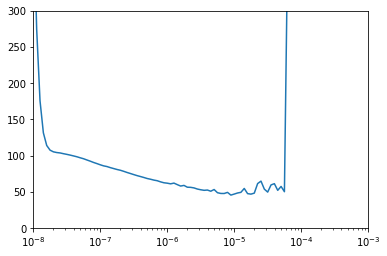

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
# find the optimal learning rate | This will be called at the callback at the end of each epoch. It will change a learning rate to a value based on the epoch number
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])  # y-axis show the loss of that epoch, x-axis shows the learning rate
plt.axis([1e-8, 1e-3, 0, 300])  # stable right around 10^(-6)

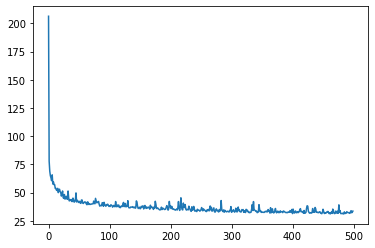

In [13]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

# ---------------

loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='Training Loss')
plt.show()

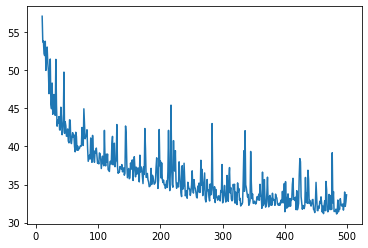

In [16]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, label='Training Loss')
plt.show()

5.669079


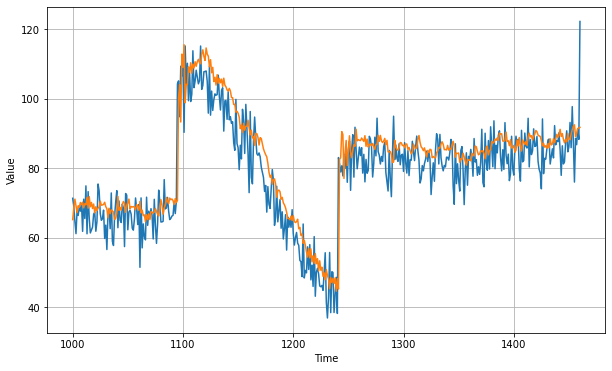

In [17]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())